<a href="https://colab.research.google.com/github/rwswzk/BusinessOOP/blob/main/MIS_515_JSSN_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Heart Attacks Clasification binary
0. cut off value optimization
1. Confussion
2. Sensitivity
3. specificity
4. ROC
5. Crossvalidation

A. Does Blood sugar corralation to heart attack risk?
B. what age has the most heart attacks?


In [ ]:
# Suppress output
%%capture
if 'google.colab' in str(get_ipython()):  # Check if running in Google Colab
    # Install required system libraries
    !apt install libspatialindex-dev
    # Install required Python packages
    !pip install fiona shapely pyproj rtree mapclassify
    !pip install geopandas
    !pip install openpyxl
    !pip install leafmap
    !pip install kaggle
    # Create a directory for storing Kaggle API key
    !mkdir ~/.kaggle

In [ ]:
import os                           # Import the os module for operating system functionality
import re                           # Import the re module for regular expressions
import pandas as pd                # Import the pandas library for data manipulation
import geopandas as gpd            # Import the geopandas library for working with geospatial data
import leafmap.foliumap as leafmap # Import the leafmap library for creating interactive maps
import matplotlib.pyplot as plt    # Import the matplotlib.pyplot module for plotting
import seaborn as sns              # Import the seaborn library for statistical data visualization
import scipy.stats as st           # linregress

In [ ]:
#Go to your Kaggle account, navigate to 'Account' > 'Create New API Token'.
#This will download a file named kaggle.json containing your API credentials.

# Import the files module from google.colab library for uploading files
from google.colab import files
# Upload the kaggle.json file
files.upload()
# Copy the uploaded kaggle.json file to the ~/.kaggle/ directory
!cp kaggle.json ~/.kaggle/
# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset using the Kaggle API
!kaggle datasets download -d sukhmandeepsinghbrar/heart-attack-dataset
# Import the zipfile module
import zipfile
# Extract the contents of the downloaded zip file to the 'data' directory
with zipfile.ZipFile('/content/heart-attack-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Saving kaggle.json to kaggle.json
  0% 0.00/15.9k [00:00<?, ?B/s]
100% 15.9k/15.9k [00:00<00:00, 23.8MB/s]


In [ ]:
excel_file_1 = 'heart-attack-dataset.zip'
data_folder = '/content'
excel_file_1_path = os.path.join(data_folder, excel_file_1)
raw_df = pd.read_csv(excel_file_1_path)
raw_df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,negative
1,20,1,94,98,46,296.0,6.75,1.060,positive
2,56,1,64,160,77,270.0,1.99,0.003,negative
3,66,1,70,120,55,270.0,13.87,0.122,positive
4,54,1,64,112,65,300.0,1.08,0.003,negative
...,...,...,...,...,...,...,...,...,...
1314,44,1,94,122,67,204.0,1.63,0.006,negative
1315,66,1,84,125,55,149.0,1.33,0.172,positive
1316,45,1,85,168,104,96.0,1.24,4.250,positive
1317,54,1,58,117,68,443.0,5.80,0.359,positive


In [ ]:
# Drop unnecessary columns from raw_df to create clean_df
#clean_df = raw_df.drop(["CK-MB","Troponin"], axis=1)

# Reset the index of clean_df
#clean_df = clean_df.reset_index()

# Reindex clean_df starting from 1
#clean_df = clean_df.reindex(range(1, len(clean_df) + 1))

# Drop the last row of clean_df
#clean_df.drop(clean_df.index[-1], inplace=True)

# Convert the 'index' column to integer type
#clean_df['index'] = clean_df['index'].astype(int)

# Display the updated clean_df
#clean_df

In [ ]:
# Drop unnecessary columns from raw_df to create clean_df
clean_df = raw_df.drop(["CK-MB", "Troponin"], axis=1)

# Reset the index of clean_df
clean_df = clean_df.reset_index(drop=True)

# Reindex clean_df starting from 1
clean_df.index = range(1, len(clean_df) + 1)

# Drop the last row of clean_df
clean_df = clean_df.iloc[:-1]

# Convert float columns to integer type (excluding the last column)
float_columns = clean_df.select_dtypes(include='float').columns
clean_df[float_columns] = clean_df[float_columns].astype(int)

# Display the updated clean_df
clean_df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,Result
1,63,1,66,160,83,160,negative
2,20,1,94,98,46,296,positive
3,56,1,64,160,77,270,negative
4,66,1,70,120,55,270,positive
5,54,1,64,112,65,300,negative
...,...,...,...,...,...,...,...
1314,86,0,40,179,68,147,negative
1315,44,1,94,122,67,204,negative
1316,66,1,84,125,55,149,positive
1317,45,1,85,168,104,96,positive


In [ ]:
for index, row in clean_df.iterrows():
    if row['Result'] == 'positive':
        clean_df.loc[index, 'Result'] = 1
    elif row['Result'] == 'negative':
        clean_df.loc[index, 'Result'] = 0
clean_df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,Result
1,63,1,66,160,83,160,0
2,20,1,94,98,46,296,1
3,56,1,64,160,77,270,0
4,66,1,70,120,55,270,1
5,54,1,64,112,65,300,0
...,...,...,...,...,...,...,...
1314,86,0,40,179,68,147,0
1315,44,1,94,122,67,204,0
1316,66,1,84,125,55,149,1
1317,45,1,85,168,104,96,1


Accuracy: 0.696969696969697
Confusion Matrix:
[[20 32]
 [ 8 72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        52
           1       0.69      0.90      0.78        80

    accuracy                           0.70       132
   macro avg       0.70      0.64      0.64       132
weighted avg       0.70      0.70      0.67       132



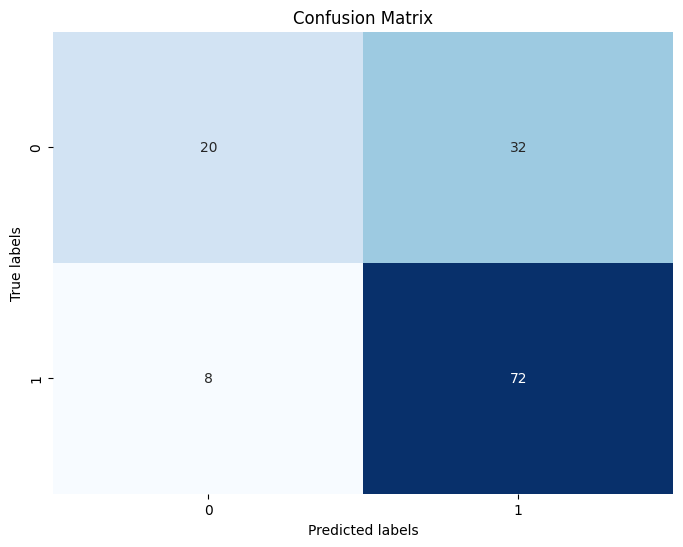

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Add this import statement

# Convert 'Result' column to numeric if it's not already
clean_df['Result'] = clean_df['Result'].astype(int)

# Using only the 'Result' column as the target variable
X = clean_df[['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar']]
y = clean_df['Result']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=55)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.5454545454545454
Confusion Matrix:
[[27 22]
 [38 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.55      0.47        49
           1       0.67      0.54      0.60        83

    accuracy                           0.55       132
   macro avg       0.54      0.55      0.54       132
weighted avg       0.58      0.55      0.55       132



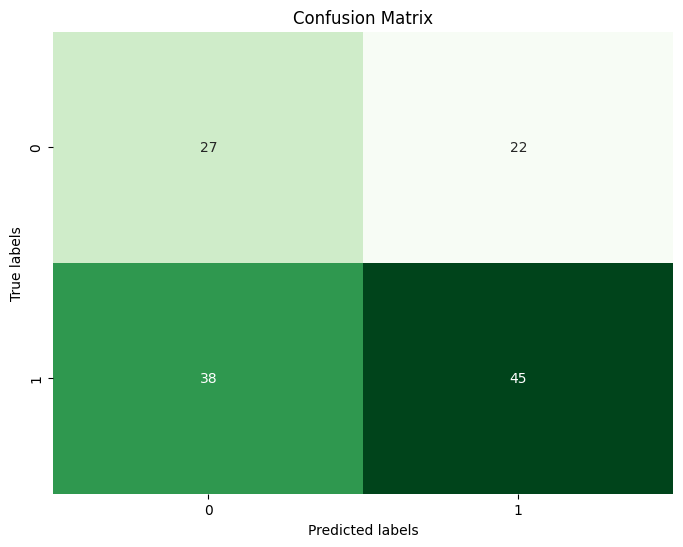

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'clean_df' is your DataFrame with features and target column 'Result'
X = clean_df[['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar']]
y = clean_df['Result']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# used hypertuning improve modle accuracy
# Use techniques like grid search or random search to find the best hyperparameters for your decision tree model,
# such as the maximum depth of the tree or the minimum number of samples required to split a node.

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')

# Use the best parameters to train the final model
best_clf = DecisionTreeClassifier(**best_params)
best_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


Best Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Score: 0.6425061163705988
Accuracy: 0.6515151515151515
Confusion Matrix:
[[19 30]
 [16 67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.39      0.45        49
           1       0.69      0.81      0.74        83

    accuracy                           0.65       132
   macro avg       0.62      0.60      0.60       132
weighted avg       0.64      0.65      0.64       132



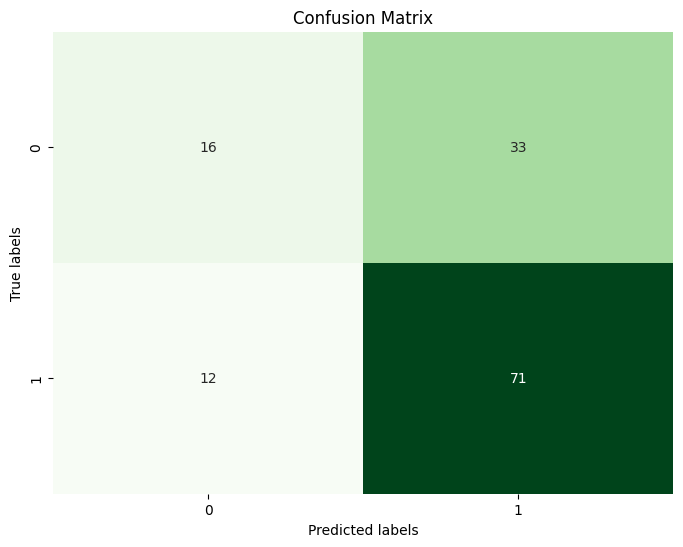

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matrix is your confusion matrix array
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
